## Unsupervised Anomaly Detection in Multivariate Time Series

### Dataset 3 - Anonymous Multivariate Time Series (sourced from Kaggle)
- Anonymous multivariate time series dataset from Kaggle
- There are 509k samples with 11 (sensor channel type) features
- Each instance / row is one moment in time.
- The actual time step is unkown.
- 443 rows are identified as rare, outliers / anomaly events (c.0.09%)

**Models Evaluated**: 
* MODEL 1. PCA with Mahalonobis Distance
* MODEL 2. K-means Clustering with Euclidean Distance
* MODEL 3. One-class Support Vector Machine (SVM)
* MODEL 4. Isolation Forest
* MODEL 5. LSTM Autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import seaborn as sns
import random

### Data Understanding

#### Load Data

In [2]:
# Load the data, merge, clean some columns and assign a timestamp column
df_set = pd.read_csv('data/Timeseries_Kaggle/TimeSeries.csv', sep = ",")
df_lab = pd.read_csv('data/Timeseries_Kaggle/labelsTimeSeries.csv', sep = ",")
df_set = pd.merge(df_set, df_lab, left_index=True, right_index=True)
df_set['label'] = df_set['label'].map({0: 'Normal', 1:'Abnormal'})
df_set.rename(columns = {'label': 'status'}, inplace = True)
df_set['timestamp'] = df_set.index

#### Data Quality Report

In [3]:
# Print a data quality report for the numeric data
pdm.generate_dq_num(df_set.drop(['timestamp', 'status'], axis = 1), df_set.columns.drop(['timestamp', 'status']))

,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
v1,float64,0,3324,-79.81,-4.970240,-2.75,78.90
v2,float64,0,3808,-87.90,-3.346117,-3.09,78.88
v3,float64,0,3973,-87.65,1.932129,0.12,76.83
v4,float64,0,589,-3.84,0.001911,0.00,4.80
v5,float64,0,825,-5.99,0.002468,0.00,5.83
v6,float64,0,556,-6.60,0.000450,0.00,3.89
v7,float64,0,1292,-275.72,42.773530,46.09,306.76
v8,float64,0,1031,-289.30,30.240553,15.86,318.20
v9,float64,0,1895,-325.23,-17.209860,1.04,323.02
v10,float64,0,13836,-89.20,-18.630128,-14.96,65.27


In [4]:
# Print a data quality report for the other data
df_set_other = df_set[['timestamp', 'status']]
pdm.generate_dq_cat(df_set_other, df_set_other.columns)

,Data Type,Missing Values,Unique Values,Min Value,Max Value
timestamp,int64,0,509632,0,509631
status,object,0,2,Abnormal,Normal


#### Plot Data

In [ ]:
# Quick plot of data to review 
PLOT_ALL = True
if PLOT_ALL:
    plot_chans = df_set.columns.drop(['timestamp', 'status'])
else:
    plot_chans = ['v2']

for sen in plot_chans:
    df_set[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

#### Data Distributions

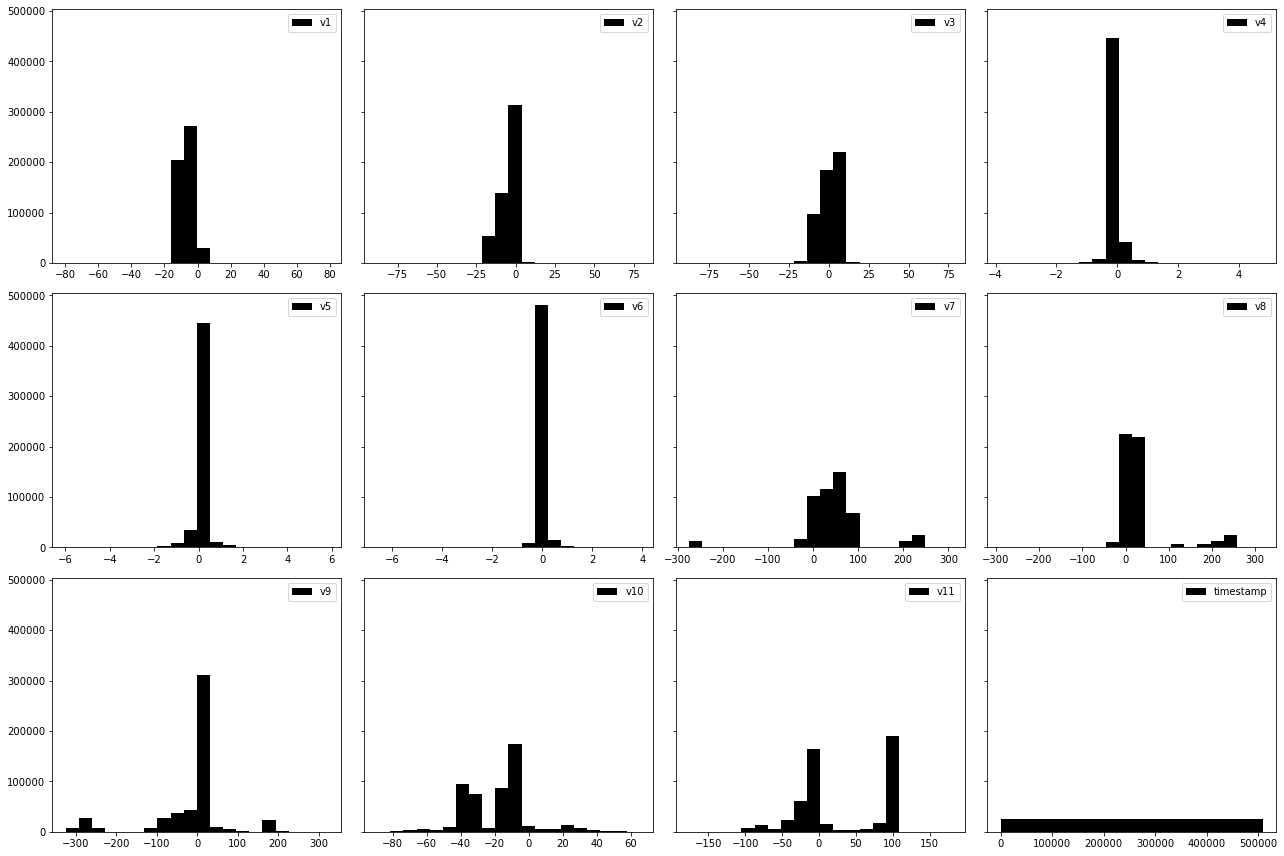

In [5]:
n_bins = 20
fig, axs = plt.subplots(3, 4, sharey=True, tight_layout=True, figsize = (18, 12))
axs = axs.ravel()
for p, ref in enumerate(df_set.columns.drop(['status'])):
    axs[p].hist(df_set[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')
    #axs[p].set_title(ref)

Several of the distributions are unusual, and possibly indicate that the data could be synthetic. Sensors v4, v5 and v6 show very little variation as indentified in the data quality report above.

In [ ]:
sns.pairplot(df_set.loc[:, df_set.columns.drop(['timestamp'])], hue='status')  

#### Examine Status (Anomaly) Distribution

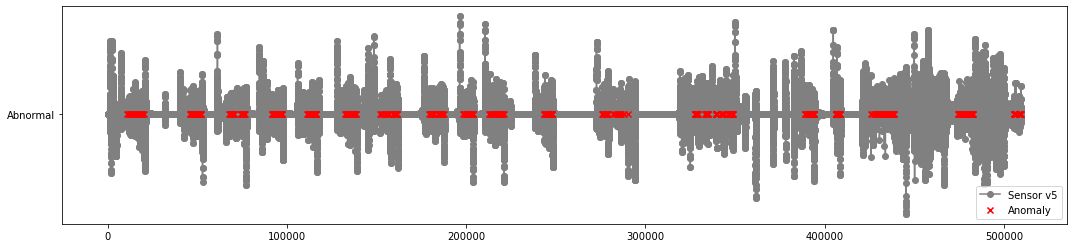

In [6]:
# Visualize status over time for the data using sensor v5 as backdrop
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['v5'], color = 'grey', marker = 'o', zorder = 1, label = 'Sensor v5')
anomaly_dat = df_set.loc[df_set['status'] == 'Abnormal', :]
anomaly_dat = anomaly_dat.assign(status_bool = 1)
ax.scatter(anomaly_dat.index, anomaly_dat['status'], color = 'red', marker = 'x', zorder = 1, label = 'Anomaly')
#ax.set_xlim(105000, 120000),
ax.legend(loc = 'lower right')
plt.show()

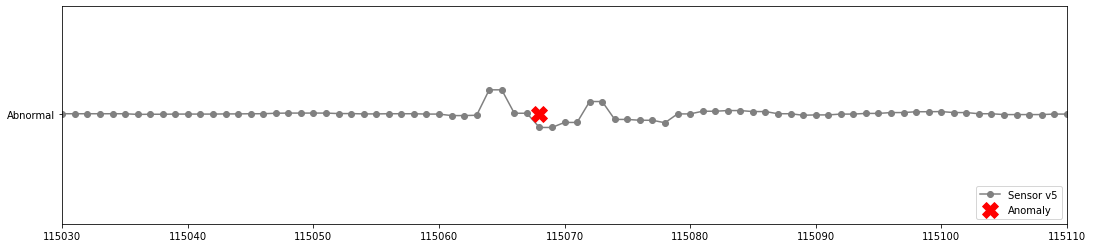

In [7]:
# Visualize machine status at one typical location (again using v5 as reference)
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['v5'], color = 'grey', marker = 'o', zorder = 1, label = 'Sensor v5')
ax.scatter(anomaly_dat.index, anomaly_dat['status'], color = 'red', marker = 'X', s = 250, zorder = 1, label = 'Anomaly')
ax.set_xlim(115030, 115110)
ax.legend(loc = 'lower right')
plt.show()

The above zoomed view of one anomaly is typical of the dataset.  Each anomaly event is a short series of points, centered on the anomaly/event label (identied by the red 'X' in the above plot.

In [8]:
normal_pts = len(df_set.loc[df_set['status'] == 'Normal', :])
anomal_pts = len(df_set.loc[df_set['status'] == 'Abnormal', :])
print('No. of normal datapoints:', "{:,}".format(normal_pts))
print('No. of anomaly datapoints:', "{:,}".format(anomal_pts))
print('Anomaly percentage: ' + str(round(100*anomal_pts/normal_pts, 3)) + '%')

No. of normal datapoints: 509,189
No. of anomaly datapoints: 443
Anomaly percentage: 0.087%


There is a significant class imbalance in the dataset.  This is quite common in predictive maintenance type problems (where recorded/labelled failures are usually quite rare.  Only 0.09% of datapoints are acually anomalies.  In order to imrove this, we will create anomaly windows centered on the anomaly label.  We will see later that this will bring the imbalance up to c.2%.  

### Data Preparation

In [9]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [11]:
# Select only the numeric data
df_num = df_set.copy(deep=True).drop(['status', 'timestamp'], axis = 1)

In [12]:
# Try rolling means
# df_num = df_num.rolling(3, min_periods=1).mean()
# Window = 2 has no affect
# Window = 3 marginal disimprovement
# Ignore

In [ ]:
# Try fast fourier transform (FFT)
cols_fft = df_num.columns
df_num_fft = np.fft.fft(df_num)
df_fft = pd.DataFrame()
for c, ref in enumerate(cols_fft):    
    #df_fft[ref] = np.abs(df_num[:,c]).tolist()
    df_fft[ref] = df_num_fft[:,c].real.tolist()

In [ ]:
#df_num = df_fft
#df_num = df_fft_bp

In [13]:
# Scale the data (standardise)
scaler = preprocessing.StandardScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['status'] = df_set['status']
df_set_scaled.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
count,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05
mean,-4.131374e-16,1.088613e-16,1.159997e-17,-6.775944e-18,4.658461e-18,4.322104e-18,5.599216e-17,6.469214e-18,-9.859974e-17,1.188997e-16,-3.926143e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.640617e+01,-1.381973e+01,-1.170753e+01,-1.780917e+01,-1.738754e+01,-3.818950e+01,-4.155051e+00,-4.937219e+00,-3.428929e+00,-3.563101e+00,-3.574645e+00
25%,-8.527029e-01,-2.784876e-01,-4.093395e-01,-8.859463e-03,-7.161738e-03,-2.600764e-03,-4.651343e-01,-4.672465e-01,2.281937e-02,-8.199575e-01,-6.292211e-01
50%,4.867151e-01,4.186051e-02,-2.368280e-01,-8.859463e-03,-7.161738e-03,-2.600764e-03,4.326651e-02,-2.221938e-01,2.031604e-01,1.853062e-01,-5.067709e-01
75%,8.506159e-01,7.642782e-01,9.864349e-01,-8.859463e-03,2.185392e-02,-2.600764e-03,2.291713e-01,-1.253161e-01,3.189348e-01,5.301556e-01,1.111383e+00
max,1.838581e+01,1.343928e+01,9.788439e+00,2.224152e+01,1.690897e+01,2.250452e+01,3.443955e+00,4.449259e+00,3.787493e+00,4.236150e+00,2.620674e+00


#### Feature Engineering

The event labels are provided only for single points.  As stated in the dataset notes, each event is actually a series of consecutive events.  From data understanding and plotting of the events, it looks like 5-10 datapoints before and after the labelled event would capture the event.  Let's first check the min and max run lengths between anomaly labelled events in the dataset.  

In [14]:
# Calculate run length encoding for the status column
rle = [(k, sum(1 for i in g)) for k, g in groupby(df_set_scaled['status'])]

In [15]:
# Check run length streaks so we can pick a suitable window to use 
# to classify an anomaly window
max_norm_streak = 0  
min_norm_streak = len(rle)  
for j in range(len(rle)):
    if rle[j][0] == 'Normal':
        chk_streak = int(rle[j][1])        
        if chk_streak > max_norm_streak:
            max_norm_streak = chk_streak
        if chk_streak < min_norm_streak:
            min_norm_streak = chk_streak    
print('Max normal run length: ', max_norm_streak)
print('Min normal run length: ', min_norm_streak)

Max normal run length:  40074
Min normal run length:  14


Let's pick 10 points as the transition window, anomaly windows will then typically be 20 datapoints long, with the actual anomaly label located in the middle.  In our modelling methods, we shall look to successfully identify the anomaly window as opposed to exactly identifying the actual anomaly label point.  This approach is more applicable for the unsupervised anomaly detection methodlogy that we are exploring.    

In [16]:
# Assign datapoints before & after the recorded anomaly to the 'anomaly window'
trans_win = 10 # points before & after

# Create map to reduce categories to two
# Not really relevant here as there are only two categories to start with
condition_map = {'Normal': 'Normal', 'Abnormal': 'Abnormal'}

In [17]:
# Add a timestamp column to help with plotting
df_set_scaled['timestamp'] = df_set_scaled.index

In [18]:
"""
Create the 'normal' and 'abonormal' dataset.
This function will separate the normal data from the abnormal/anomaly data.
Again, the anomaly data is n points before & after each anomaly labelled point.
"""
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win, 
    keep = 'Normal'
)

Input segement categories:  ['Normal' 'Abnormal']
Categories after mapping:  ['Normal' 'Abnormal']
Run length encoding:  [('Normal', 10702), ('Abnormal', 1), ('Normal', 721), ('Abnormal', 1), ('Normal', 460), ('Abnormal', 1), ('Normal', 434), ('Abnormal', 1), ('Normal', 382), ('Abnormal', 1), ('Normal', 335), ('Abnormal', 1), ('Normal', 430), ('Abnormal', 1), ('Normal', 391), ('Abnormal', 1), ('Normal', 510), ('Abnormal', 1), ('Normal', 430), ('Abnormal', 1), ('Normal', 2221), ('Abnormal', 1), ('Normal', 242), ('Abnormal', 1), ('Normal', 367), ('Abnormal', 1), ('Normal', 386), ('Abnormal', 1), ('Normal', 354), ('Abnormal', 1), ('Normal', 303), ('Abnormal', 1), ('Normal', 285), ('Abnormal', 1), ('Normal', 229), ('Abnormal', 1), ('Normal', 393), ('Abnormal', 1), ('Normal', 333), ('Abnormal', 1), ('Normal', 25589), ('Abnormal', 1), ('Normal', 339), ('Abnormal', 1), ('Normal', 283), ('Abnormal', 1), ('Normal', 301), ('Abnormal', 1), ('Normal', 272), ('Abnormal', 1), ('Normal', 203), ('Abno

>
Skipping Normal segment(s)...
>
Remove rows:  [12310, 12330]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [12693, 12713]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13029, 13049]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13460, 13480]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13852, 13872]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [14363, 14383]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [14794, 14814]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17016, 17036]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17259, 17279]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17627, 17647]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [18014, 18034]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [18369, 18389]
Removing 21 rows...
>
Sk

>
Skipping Normal segment(s)...
>
Remove rows:  [133237, 133257]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133462, 133482]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133597, 133617]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133740, 133760]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133892, 133912]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [134434, 134454]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136070, 136090]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136355, 136375]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136647, 136667]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136910, 136930]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [137299, 137319]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [137552, 137572]


>
Skipping Normal segment(s)...
>
Remove rows:  [243843, 243863]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [244146, 244166]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [244440, 244460]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [244999, 245019]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245293, 245313]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245640, 245660]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245895, 245915]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [246178, 246198]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [246838, 246858]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247084, 247104]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247312, 247332]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247463, 247483]


>
Skipping Normal segment(s)...
>
Remove rows:  [348560, 348580]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [348679, 348699]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [388754, 388774]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [389274, 389294]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [389691, 389711]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [390108, 390128]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [390506, 390526]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [390799, 390819]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391071, 391091]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391296, 391316]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391601, 391621]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391919, 391939]


>
Skipping Normal segment(s)...
>
Remove rows:  [474629, 474649]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [474857, 474877]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [475111, 475131]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [475353, 475373]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [475613, 475633]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [475850, 475870]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [476108, 476128]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [476322, 476342]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [476540, 476560]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [477729, 477749]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [477964, 477984]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [478170, 478190]


In [19]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print(f'No. of normal rows: {"{:,}".format(len(df_norm))} ({round(100*len(df_norm)/tot_rows)}%)')
print(f'No. of abnorm rows: {"{:,}".format(len(df_abnorm))} ({round(100*len(df_abnorm)/tot_rows)})%')

No. of normal rows: 500,352 (98%)
No. of abnorm rows: 9,280 (2)%


The abnormal data (anomaly windows) now make up approximately 2% of the data.

In [20]:
# Create separate numeric datasets for training and testing
df_train = df_norm
df_train = df_train.drop(['status', 'timestamp'], axis = 1)                      
#df_train = df_train.iloc[500:,]

df_test1 = df_abnorm
df_test1 = df_test1.drop(['status', 'timestamp'], axis = 1) 

Most of the models that we will experiment with will be training on 'normal' data and testing on the 'abnormal' data.

### MODEL 1.  Principal Component Analysis (PCA)

In [21]:
# Define the PCA model (all compoments)
n_comps = 10 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.29  0.187 0.15  0.137 0.082 0.071 0.03  0.027 0.021 0.004]


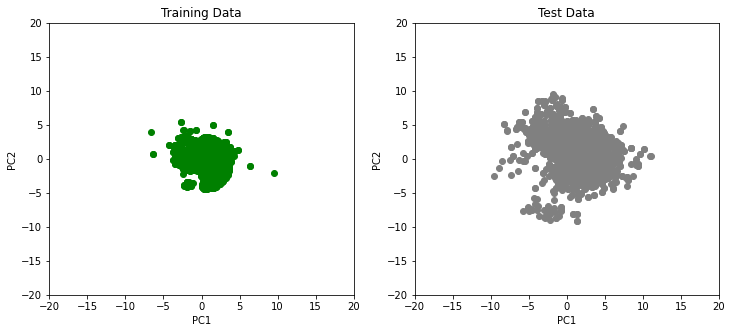

In [22]:
# Plot PC1 vs PC2 for training & test sets
xlims = 20
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-xlims, xlims)
ax0.set_ylim(-xlims, xlims)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-xlims, xlims)
ax1.set_ylim(-xlims, xlims)
ax1.set_title('Test Data')

plt.show()

The test data (above right) that is projected into the training (normal operating) PCA space is more spread out.  It should be possible to use this distribution to identify anomaly windows.

In [23]:
# Now Calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2, etc. (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [-9.997e-18 -5.908e-17 -3.388e-17  3.613e-17  9.291e-18 -1.727e-17
  4.345e-17  6.317e-17  2.323e-17 -9.248e-17]
Minimum & maximum MD in training set: 0.7395504698371765 46.21451825455277
Minimum & maximum MD in test set 1  : 0.967227603721574 92.85652069617595
Threshold value for flagging an anomaly is 7.81


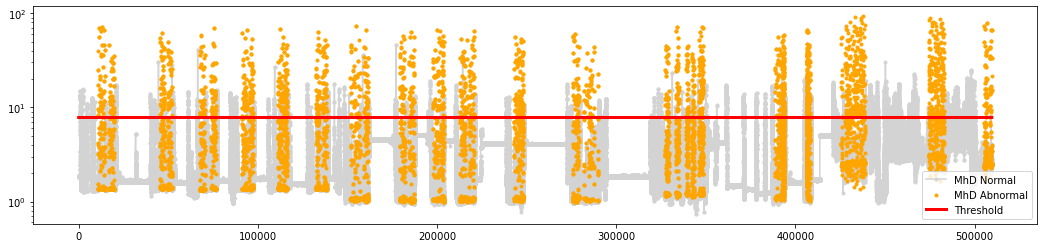

In [24]:
# Prep data & plot
mh_dat = df_set_scaled[['timestamp', 'v5']]
mh_train = pd.DataFrame({'timestamp':df_train.index, 'dist_train':dist_train})
mh_dat = pd.merge(mh_dat, mh_train, how='left', on='timestamp')
mh_test1 = pd.DataFrame({'timestamp':df_test1.index, 'dist_test1':dist_test1})
mh_dat = pd.merge(mh_dat, mh_test1, how='left', on='timestamp')
mh_dat['threshold'] = threshold

# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(mh_dat['timestamp'], mh_dat['dist_train'], color = 'lightgrey', marker = '.', zorder = 1, label = 'MhD Normal')
ax.scatter(mh_dat['timestamp'], mh_dat['dist_test1'], color = 'orange', marker = '.', zorder = 2, label = 'MhD Abnormal')
ax.plot(mh_dat['timestamp'], mh_dat['threshold'], color = 'red', marker = None, zorder = 3, linewidth=3, label = 'Threshold')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

The above plot shows the Mahalonobis distance (MhD) calculated for 'normal' data in grey and 'abnormal' data in orange.  The red line is the threshold for MhD as calculated above (based on a factor times the mean).  All points above the threshold would be classified as an anomaly.

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


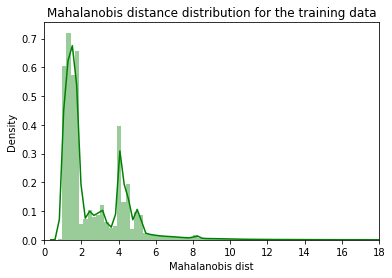

In [25]:
# Plot the distrubution of Mahalobis distance
plt.figure()
sns.distplot(dist_train, bins = 200, kde = True, color = 'green')
plt.xlim([0.0, 18])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [26]:
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)

There are 9369 anomalies in the test set out of 500352 points
> Corresponding to 1.87%
There are 3167 anomalies in the test set out of 9280 points
> Corresponding to 34.13%


From the above results, 1.9% of normal data has been classified as an anomaly (False Positives) and 34% of anomaly window points are classified as an anomaly.  We need to process this data further in order to calculate what percentage of anomaly windows have been identified as an anomaly, i.e., at least one point within the window classified as an anomaly.  

In [27]:
# First, lets define plot xlims for each anomaly window plot.
# We want to be able to plot each window independently to assess model performance.
df_ser = df_set.loc[df_set['status'] == 'Abnormal',:]
n_plots = len(df_ser)
buff = 20
start_win = []
ender_win = []
for r in range(n_plots):
    start_win.append(df_ser.iloc[r, 12] - buff)
    ender_win.append(df_ser.iloc[r, 12] + buff)

In [28]:
# Add missing data to gaps between anomalies
df_set.reset_index(drop = True, inplace = True)
anomaly_train.reset_index(drop = True, inplace = True)
preds_test = pd.merge(df_set, anomaly_train, how='left', on='timestamp')
anomaly1.reset_index(drop = True, inplace = True)
preds_test = pd.merge(df_set['timestamp'], anomaly1, how='left', on='timestamp')

# Now lets count the number of anomaly windows 
# and check each window for a breach of the threshold
# i.e., at least one point breaching the threshold in the window
preds_test.loc[preds_test['Thresh'].isnull(), 'zone'] = 'Normal'
preds_test.loc[preds_test['Thresh'].notnull(), 'zone'] = 'Anomaly'
preds_test['anomaly_number'] = 0
preds_test['v5'] = df_set_scaled['v5']
preds_test['status'] = df_set_scaled['status']

# Create some params that will help with visualization of anomaly 
# windows + analysis of prediction results 
preds_test = preds_test.assign(v5_win = preds_test['v5'])
preds_test.loc[preds_test['zone'] == 'Normal', ['v5_win']] = None
preds_test = preds_test.assign(v5_win_anom = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_win_anom']] = None
preds_test.loc[preds_test['zone'] != 'Anomaly', ['v5_win_anom']] = None
preds_test = preds_test.assign(v5_win_actual_anom = preds_test['v5'])
preds_test.loc[preds_test['status'] != 'Abnormal', ['v5_win_actual_anom']] = None
preds_test = preds_test.assign(v5_false_pos = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_false_pos']] = None
preds_test.loc[preds_test['zone'] != 'Normal', ['v5_false_pos']] = None
#preds_test.iloc[10690:10715,:]

In [29]:
"""
Create zones of normal and abnormal for run length encoding
Use rle for checking if an anomaly was detected in anomaly zone/window
    rule_type 1: Simple check for presence of anomaly
    rule_type 1: Check for max distance in window and comapre to threshold

"""
def calculate_anomaly_zone_acc(dat, rule_type=1):
    # Calculate the run length encoding
    rle_anomalies = [(k, sum(1 for i in g)) for k, g in groupby(dat['zone'])]

    # Loop through & number anomaly windows based on run length encoding
    dat['anomaly_number'] = 0
    prev = 0
    counter = 1
    for j in range(len(rle_anomalies)):
        if rle_anomalies[j][0] == 'Normal':
            prev = prev + rle_anomalies[j][1]
            next
        elif j == 0:
            prev = prev + rle_anomalies[j][1]
            dat.loc[dat.index.isin(list(range(0, rle_anomalies[j][1], 1))), 'anomaly_number'] = counter 
            counter += 1
        else:        
            goto = prev + rle_anomalies[j][1]
            dat.loc[dat.index.isin(list(range(prev, goto, 1))), 'anomaly_number'] = counter
            prev = prev + rle_anomalies[j][1]
            counter += 1

    # Now summarise and count how many were missed, i.e., false negatives
    count_anomaly_blks = dat.loc[dat['anomaly_number'] != 0,:]
    count_anomaly_blks = max(count_anomaly_blks['anomaly_number'])
    anom_chk = []
    anom_num = []
   
    for a in range(count_anomaly_blks):
        anom_num.append(a + 1)
        dat_tmp = dat.loc[dat['anomaly_number'] == a + 1,:]
        if rule_type == 1:
            pred = max(dat_tmp['prediction'])    
            if pred == 1:
                anom_chk.append(1)
            else: 
                anom_chk.append(0)
        elif rule_type == 2:
            max_mobdi = max(dat_tmp['Mob dist'])
            max_thres = max(dat_tmp['Thresh'])
            if max_mobdi >= max_thres:
                anom_chk.append(1)
            else: 
                anom_chk.append(0)
        else:
            print('Invalid rule type specified...')

    result_summary = pd.DataFrame()
    result_summary['anom_num'] = anom_num
    result_summary['anom_chk'] = anom_chk
    FN = len(result_summary.loc[result_summary['anom_chk'] == 0,:])
    TP = len(result_summary.loc[result_summary['anom_chk'] == 1,:])
    AP = len(result_summary)
    FN_per = round(100*FN/AP, 2)
    TP_per = round(100*TP/AP, 2)
    print('Model performance for anomaly windows:')
    print('======================================')
    print(f'Found {TP} out of {AP} (TP: {TP_per}%)')
    print(f'Missed {FN} out of {AP} (FN: {FN_per}%)\n')    
    print(result_summary.loc[result_summary['anom_chk'] == 0,:])

In [30]:
calculate_anomaly_zone_acc(preds_test, rule_type=2)

Model performance for anomaly windows:
Found 426 out of 430 (TP: 99.07%)
Missed 4 out of 430 (FN: 0.93%)

     anom_num  anom_chk
82         83         0
180       181         0
267       268         0
270       271         0


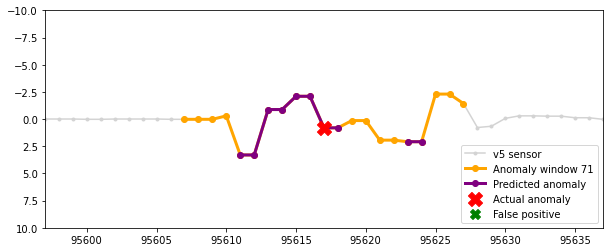

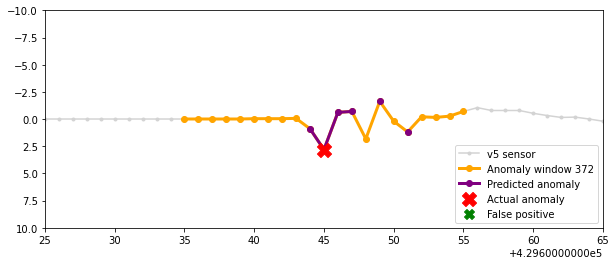

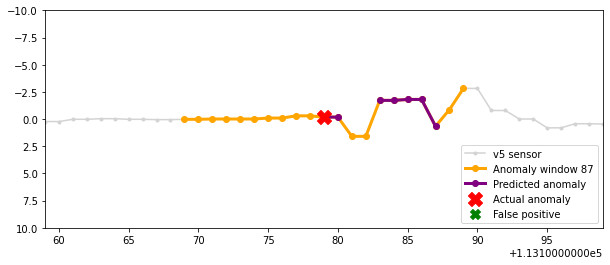

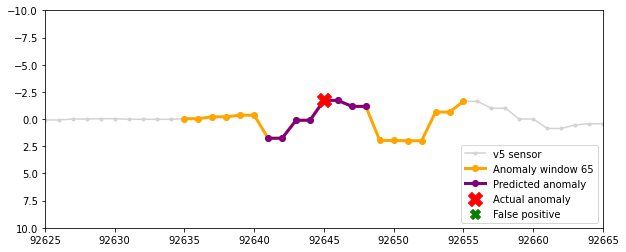

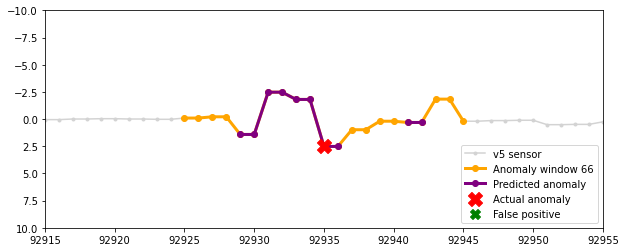

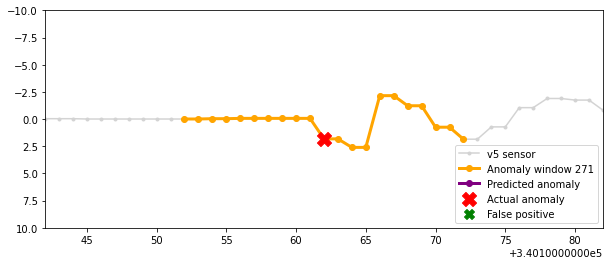

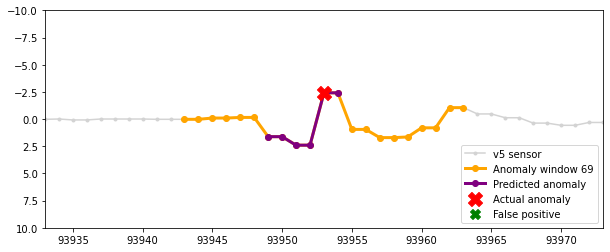

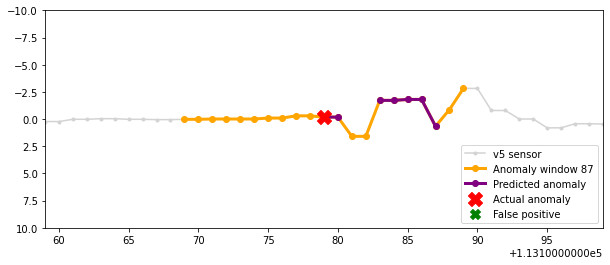

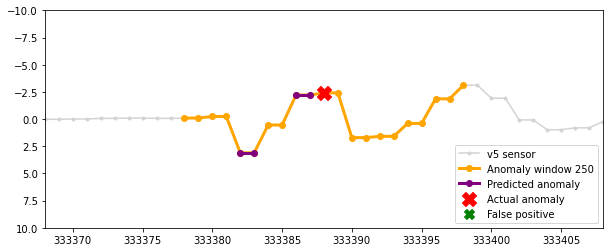

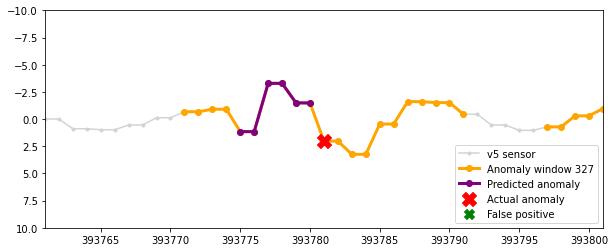

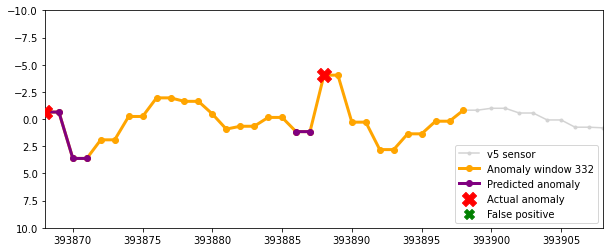

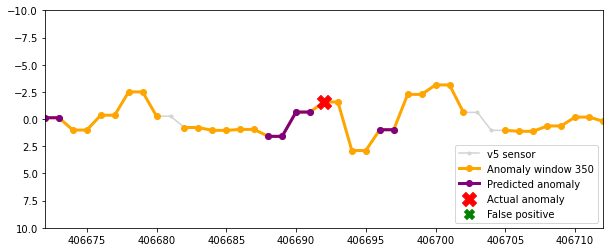

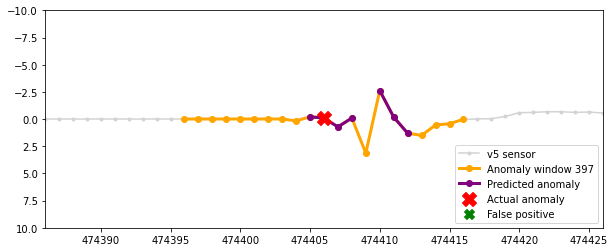

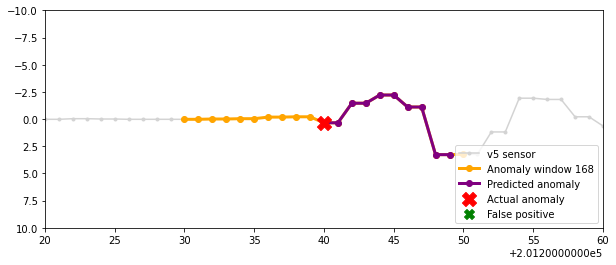

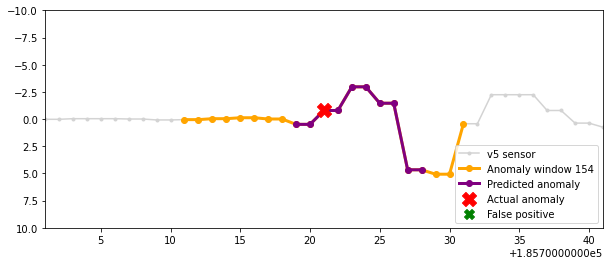

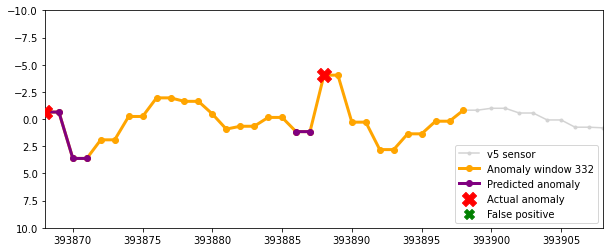

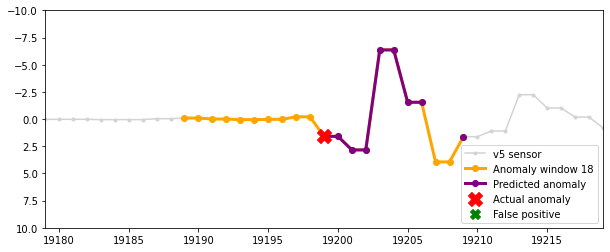

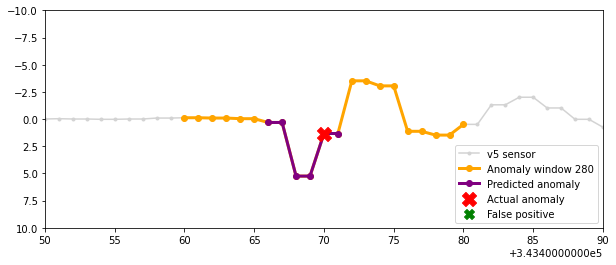

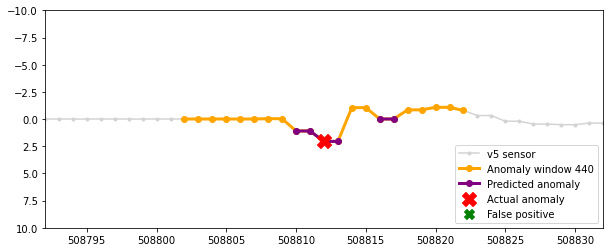

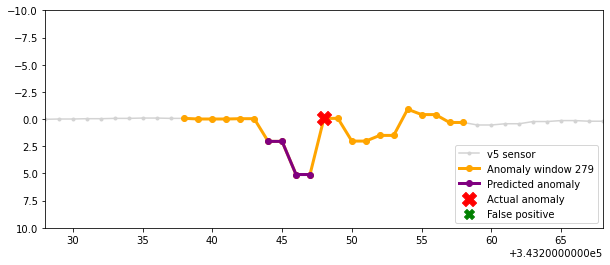

In [31]:
# Now lets plot each window and verify the results
# Inspect the windows that were missed (false negatives)

# By default, plot only a selection of 20 plots (randomly selected)
# Note: It takes a few minutes to plot all & can consume a lot of memory.
PLOT_ALL = False

random_list = []
for i in range(0, 20):
    n = random.randint(1, n_plots)
    random_list.append(n)

if PLOT_ALL:
    plots_list = range(n_plots)
else:
    plots_list = random_list
    
for p in plots_list:
    fig, ax = plt.subplots(figsize = (10, 4))
    ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'v5 sensor')        
    ax.plot(preds_test['timestamp'], preds_test['v5_win'], color = 'orange', marker = 'o', zorder = 2, linewidth = 3, label = f'Anomaly window {p+1}')
    ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'purple', marker = 'o', zorder = 2, linewidth = 3, label = 'Predicted anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', s = 200, zorder = 3, label = 'Actual anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = 'X', s = 100, zorder = 2, label = 'False positive')
    ax.legend(loc = 'lower right')        
    ax.set_ylim(10, -10)
    ax.set_xlim(start_win[p], ender_win[p])
    plt.show()

The above plots show each of the anomaly windows using sensor v5 as a backdrop.  The anomaly window is show using orange highlighted points and line.  Purple points are points that have been classified as anomalies by the model.  The actual point that is labelled as an anomaly in the dataset is shown with a red 'X'.  False positives are shown using a green 'X' (where the appear in the plot windows). 

### MODEL 2. Clustering & Euclidean Distance
Try a K-means clustering approach where we group together usual combinations of features. The points that are far from the cluster are points with an unusual combination of features and these points will be classified as anomalies.

In [32]:
from sklearn.cluster import KMeans

In [34]:
# Remind ourselves of the base data with the 11x features
df_num = df_set.copy(deep=True).drop(['status', 'timestamp'], axis = 1)
df_num

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
...,...,...,...,...,...,...,...,...,...,...,...
509627,-8.27,-11.98,-9.35,0.0,0.0,0.0,30.00,8.24,13.90,-7.06,-32.33
509628,-8.27,-12.00,-9.41,0.0,0.0,0.0,30.00,8.24,13.90,-7.07,-32.34
509629,-8.25,-11.98,-9.40,0.0,0.0,0.0,30.00,8.24,13.90,-7.08,-32.35
509630,-8.27,-12.00,-9.41,0.0,0.0,0.0,30.00,8.24,13.90,-7.09,-32.36


In [35]:
# Standardize the features
data = df_set.drop(['status', 'timestamp'], axis = 1)
scaler1 = preprocessing.StandardScaler()
np_scaled = scaler1.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# Standardize these 2 new features
scaler2 = preprocessing.StandardScaler()
np_scaled = scaler2.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Evaluate effect of using robust PCA 
# Robust PCA
#L, S = pdm.R_pca(df_set.drop(['status', 'timestamp'], axis = 1)).fit()
#scaler3 = preprocessing.StandardScaler()
#np_scaled = scaler3.fit_transform(L)
#data = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
#rpca = PCA(n_components=2)
#data = rpca.fit_transform(data)

# Standardize these 2 new features
#scaler4 = preprocessing.StandardScaler()
#np_scaled = scaler4.fit_transform(data)
#data = pd.DataFrame(np_scaled)

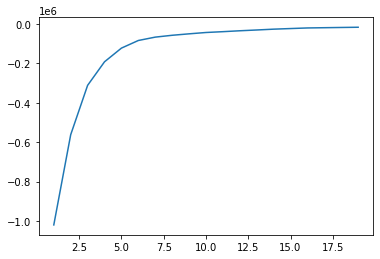

In [36]:
# Calculate with different numbers of centroids & plot the loss (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=1234).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [37]:
# Choose 15 centroids & add these data to the base dataframe
#kmeans_model = KMeans(n_clusters=15, random_state=1234).fit(data)
df = df_num
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

1     91066
8     79244
6     74892
0     66124
5     51366
2     31835
3     24688
12    19968
9     14243
4     13472
11    13234
7     11557
14    10379
10     7053
13      511
Name: cluster, dtype: int64

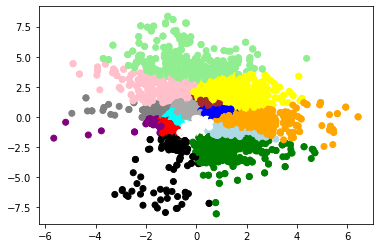

In [38]:
# Plot the different clusters with the 2x PCA component features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [39]:
"""
Create a function that returns a list of distances 
between each point & its distance to the closest centroid
Use 'np.linalg.norm' as the Euclidean distance is the l2 norm, 
and the default value of the ord parameter in numpy.linalg.norm is 2.
"""
def getDistanceByPoint(dat, model):
    distance = []
    for i in range(0, len(dat)):
        Xa = np.array(dat.loc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.append(np.linalg.norm(Xa - Xb))
    return distance

In [40]:
# Get the distance between each point and its nearest centroid. 
# The biggest distances will be considered as anomalies (using outlier_fraction assumption)
distance = pd.Series(getDistanceByPoint(data, kmeans[14]))

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


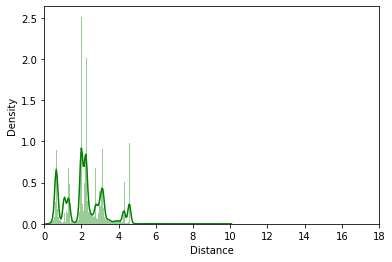

In [41]:
plt.figure()
sns.distplot(distance, bins = 200, kde = True, color = 'green');
plt.xlim([0.0, 18])
plt.xlabel('Distance')
plt.show()

In [42]:
outliers_fraction = 0.10
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Prediction will contain the anomaly result (0:normal, 1:anomaly) 
df['prediction'] = (distance >= threshold).astype(int)

In [43]:
print(f'Selected anomaly percentage: {100 * outliers_fraction}%')
print('Selected threshold distance:', round(threshold, 3))

Selected anomaly percentage: 10.0%
Selected threshold distance: 3.566


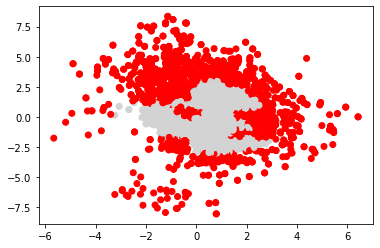

In [44]:
# Visualisation of anomaly with cluster view
fig, ax = plt.subplots()

# Use a simple color mapping
colors = {0:'lightgrey', 1:'red'}

# Now plot
ax.scatter(df['principal_feature1'], df['principal_feature2'], c = df['prediction'].apply(lambda x: colors[x]))
plt.show()

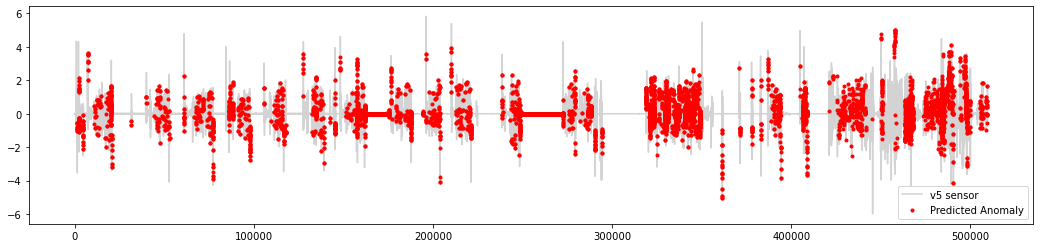

In [45]:
# Quick overview visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))

a = df.loc[df['prediction'] == 1, ['v5']] # anomaly using v5 sensor as backdrop

ax.plot(df.index, df['v5'], color='lightgrey', zorder=1, label = 'v5 sensor')
ax.scatter(a.index, a['v5'], color='red', marker='.', zorder=2, label = 'Predicted Anomaly')
ax.legend(loc = 'lower right')  
plt.show()

Anomalies appear to be reasonably well distributed in the expected zones.  Let's move on to evaluate the results in more detail. 

In [46]:
# Check the anomaly fraction (outlier fraction), should be what we
# we set it to in outlier_fraction
anomaly_count = round(100*len(a)/len(df), 2)
print(f'Anomaly fraction check is {anomaly_count}%')

Anomaly fraction check is 10.0%


In [47]:
# Add the zone (Normal or Anomaly) to the dataframe we are using to analyse results
# Let's also recheck row counts
df['zone'] = 'tbc'
df.loc[df.index.isin(df_train.index), 'zone'] = 'Normal'
df.loc[df.index.isin(df_test1.index), 'zone'] = 'Anomaly'

In [48]:
count_norm = sum(df['zone'] == 'Normal')
count_anom = sum(df['zone'] == 'Anomaly')
print(f'Check normal point count: {"{:,}".format(count_norm)}')
print(f'Check anomaly zone point count:, {"{:,}".format(count_anom)}')
print('Check tbc count (should be zero):', sum(df['zone'] == 'tbc'))

Check normal point count: 500,352
Check anomaly zone point count:, 9,280
Check tbc count (should be zero): 0


In [49]:
# Prep a prediction summary for plotting & analysis of results
if 'preds_test' in globals(): del preds_test
preds_test = df
preds_test['timestamp'] = preds_test.index
preds_test['status'] = df_set_scaled['status']

# Create some params that will help with visualization of anomaly 
# windows + analysis of prediction results 
preds_test = preds_test.assign(v5_win = preds_test['v5'])
preds_test.loc[preds_test['zone'] == 'Normal', ['v5_win']] = None
preds_test = preds_test.assign(v5_win_anom = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_win_anom']] = None
preds_test.loc[preds_test['zone'] != 'Anomaly', ['v5_win_anom']] = None
preds_test = preds_test.assign(v5_win_actual_anom = preds_test['v5'])
preds_test.loc[preds_test['status'] != 'Abnormal', ['v5_win_actual_anom']] = None
preds_test = preds_test.assign(v5_false_pos = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_false_pos']] = None
preds_test.loc[preds_test['zone'] != 'Normal', ['v5_false_pos']] = None

In [50]:
# Check output is as expected
#preds_test.loc[10690:10715,:]

In [51]:
# Calculate accuracy for anomaly zone predictions
calculate_anomaly_zone_acc(preds_test)

Model performance for anomaly windows:
Found 411 out of 430 (TP: 95.58%)
Missed 19 out of 430 (FN: 4.42%)

     anom_num  anom_chk
7           8         0
71         72         0
72         73         0
82         83         0
109       110         0
148       149         0
216       217         0
218       219         0
227       228         0
231       232         0
238       239         0
248       249         0
264       265         0
267       268         0
270       271         0
273       274         0
277       278         0
278       279         0
424       425         0


In [52]:
"""
Create a function to evaluate accuracy in the normal zones
Key focus here will be false positive rate, this should be as low as possible
for an effective solution (i.e., mininse number of 'false alarms')
"""
def calculate_normal_zone_acc(dat):
    norm_rows = dat.loc[preds_test['zone'] == 'Normal', ['zone', 'prediction']]
    AR = len(norm_rows)
    print('Model performance for normal windows:')
    print('======================================')
    print('Total rows:', "{:,}".format(AR))
    TN = len(norm_rows.loc[norm_rows['prediction'] == 0, ['zone', 'prediction']])
    FP = len(norm_rows.loc[norm_rows['prediction'] == 1, ['zone', 'prediction']])
    print(f'TN: True negative (normal pts correctly assigned normal): {"{:,}".format(TN)} ({round(100*TN/AR, 2)}%)')
    print(f'FP: False positive (normal pts incorrectly assigned anomaly): {"{:,}".format(FP)} ({round(100*FP/AR, 2)}%)')

In [53]:
calculate_normal_zone_acc(preds_test)

Model performance for normal windows:
Total rows: 500,352
TN: True negative (normal pts correctly assigned normal): 451,201 (90.18%)
FP: False positive (normal pts incorrectly assigned anomaly): 49,151 (9.82%)


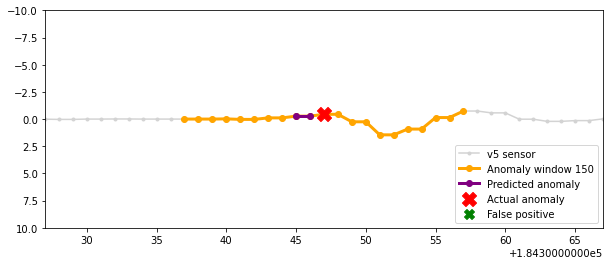

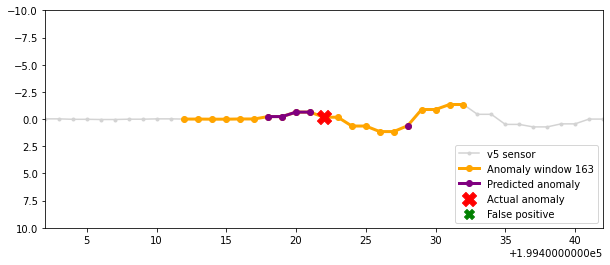

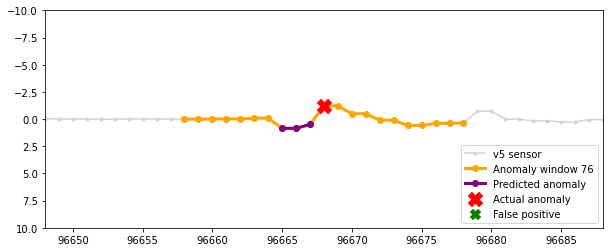

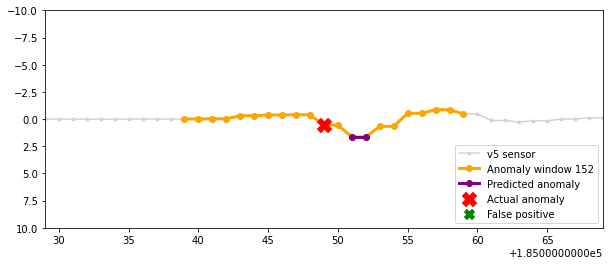

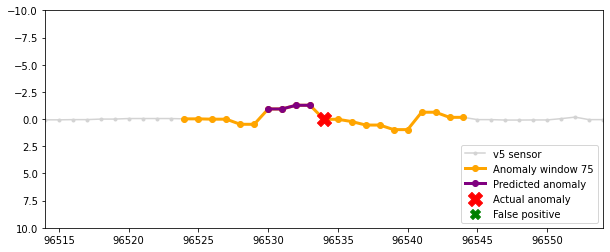

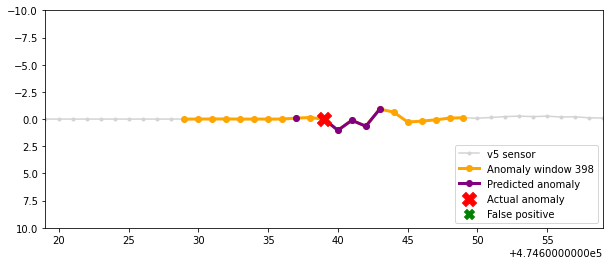

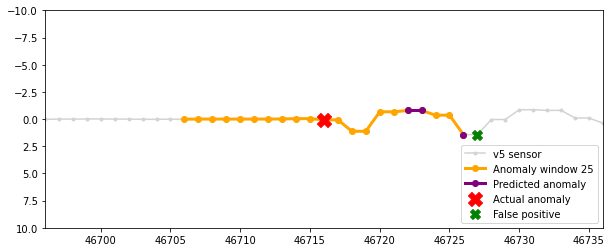

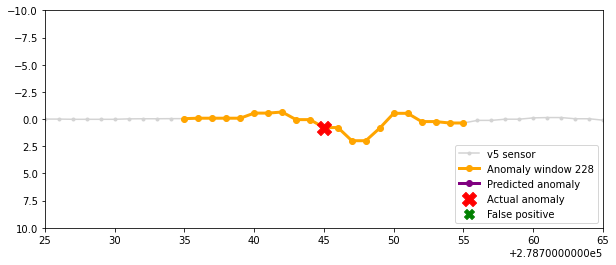

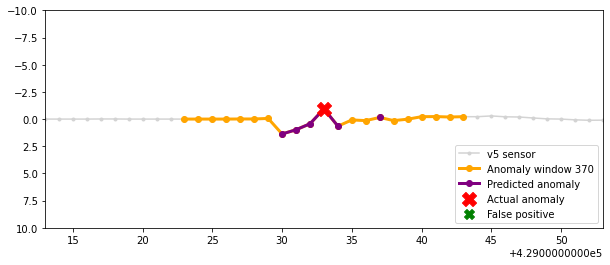

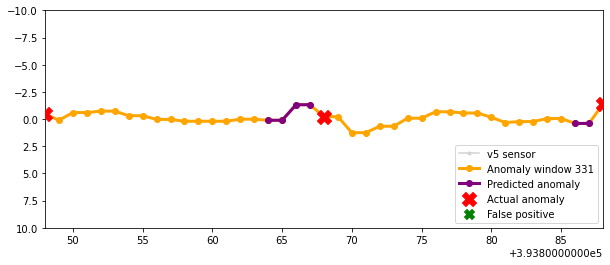

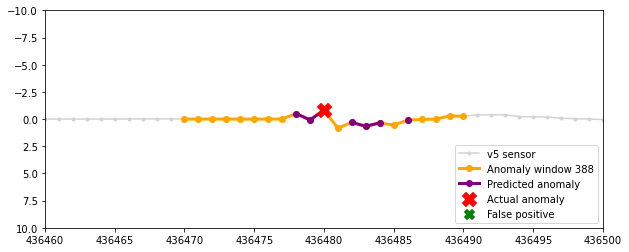

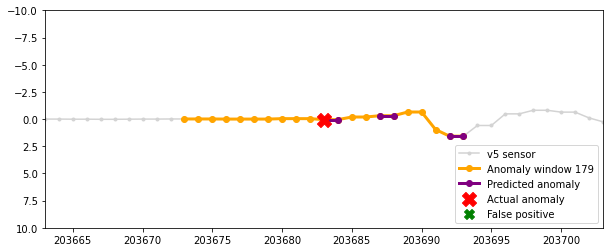

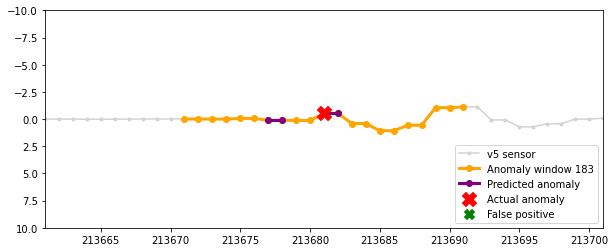

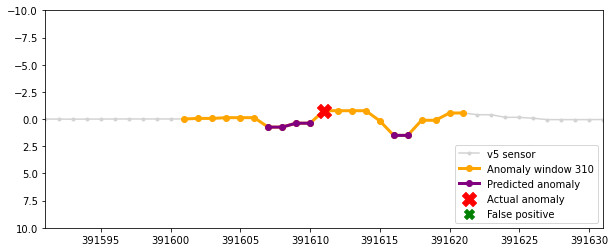

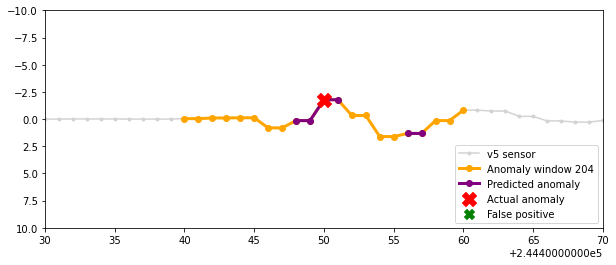

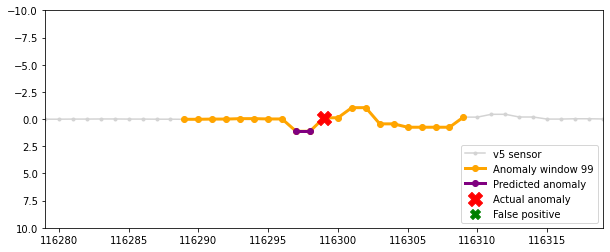

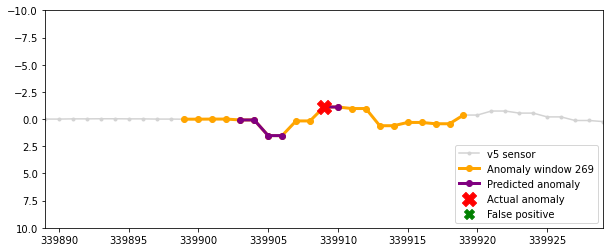

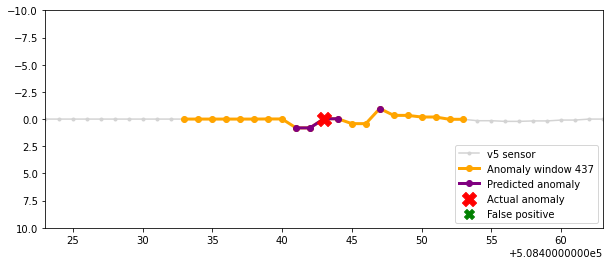

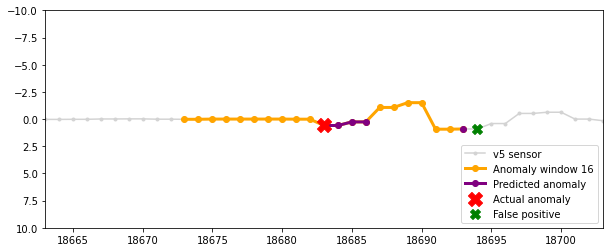

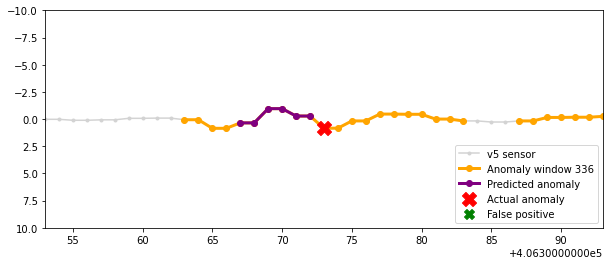

In [54]:
# Now lets plot each window and verify the results
# Inspect the windows that were missed (false negatives)

# By default, plot only a selection of 20 plots (randomly selected)
# Note: It takes a few minutes to plot all & can consume a lot of memory.
PLOT_ALL = False

random_list = []
for i in range(0, 20):
    n = random.randint(1, n_plots)
    random_list.append(n)

if PLOT_ALL:
    plots_list = range(n_plots)
else:
    plots_list = random_list
    
for p in plots_list:
    fig, ax = plt.subplots(figsize = (10, 4))
    ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'v5 sensor')        
    ax.plot(preds_test['timestamp'], preds_test['v5_win'], color = 'orange', marker = 'o', zorder = 2, linewidth = 3, label = f'Anomaly window {p+1}')
    ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'purple', marker = 'o', zorder = 2, linewidth = 3, label = 'Predicted anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', s = 200, zorder = 3, label = 'Actual anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = 'X', s = 100, zorder = 2, label = 'False positive')
    ax.legend(loc = 'lower right')        
    ax.set_ylim(10, -10)
    ax.set_xlim(start_win[p], ender_win[p])
    plt.show()

### MODEL 3. One-class Support Vector Machine (SVM)

SVMs use hyperplanes in multi-dimensional space to separate one class of observations from another. In a one-class SVM problem, all data belongs to a single class (often the normal class). The model is trained to learn these 'normal' conditions, so that when a new data is encountered, it can identify whether it should belong to trained class or not. If not, the new data is labeled as an anomaly.

In [55]:
from sklearn.svm import OneClassSVM

In [56]:
# Train a one-class SVM 
# nu = contamination 
svm_model =  OneClassSVM(nu = 0.01) # 1%
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.01)

In [57]:
# Predict for train set 
preds = pd.Series(svm_model.predict(df_train))
test = pd.DataFrame({'v5':pd.Series(df_train['v5'])})
svm_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
v5 = df_train['v5']
v5 = v5.reset_index()
v5.drop('timestamp', axis = 1, inplace = True)
svm_out['v5'] = v5
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'v5']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

5008 out of 500352 (1.0%)


In [58]:
# Predict for test set
preds = pd.Series(svm_model.predict(df_test1))
test = pd.DataFrame({'v5':pd.Series(df_test1['v5'])})
svm_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
v5 = df_test1['v5']
v5 = v5.reset_index()
v5.drop('timestamp', axis = 1, inplace = True)
svm_out['v5'] = v5
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'v5']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

3260 out of 9280 (35.13%)


In [59]:
# Reword results so that we can drill into them in more detail
df_all = df_set_scaled.drop(['status', 'timestamp', 'id'], axis = 1)

In [60]:
if 'preds_test' in globals(): del preds_test
preds_test = pd.DataFrame({'prediction':svm_model.predict(df_all)})
preds_test['timestamp'] = df_set_scaled.index
preds_test['prediction'] = preds_test['prediction'].map({1: 0, -1: 1})
preds_test['status'] = df_set_scaled['status']
preds_test.loc[preds_test['timestamp'].isin(df_train.index), 'zone'] = 'Normal'
preds_test.loc[preds_test['timestamp'].isin(df_test1.index), 'zone'] = 'Anomaly'
preds_test['v5'] = df_set_scaled['v5'] 

# Create some params that will help with visualization of anomaly 
# windows + analysis of prediction results 
preds_test = preds_test.assign(v5_win = preds_test['v5'])
preds_test.loc[preds_test['zone'] == 'Normal', ['v5_win']] = None
preds_test = preds_test.assign(v5_win_anom = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_win_anom']] = None
preds_test.loc[preds_test['zone'] != 'Anomaly', ['v5_win_anom']] = None
preds_test = preds_test.assign(v5_win_actual_anom = preds_test['v5'])
preds_test.loc[preds_test['status'] != 'Abnormal', ['v5_win_actual_anom']] = None
preds_test = preds_test.assign(v5_false_pos = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_false_pos']] = None
preds_test.loc[preds_test['zone'] != 'Normal', ['v5_false_pos']] = None
#preds_test.iloc[10690:10715,:]

In [61]:
calculate_normal_zone_acc(preds_test)
print('\n')
calculate_anomaly_zone_acc(preds_test)

Model performance for normal windows:
Total rows: 500,352
TN: True negative (normal pts correctly assigned normal): 495,344 (99.0%)
FP: False positive (normal pts incorrectly assigned anomaly): 5,008 (1.0%)


Model performance for anomaly windows:
Found 428 out of 430 (TP: 99.53%)
Missed 2 out of 430 (FN: 0.47%)

     anom_num  anom_chk
180       181         0
267       268         0


In [62]:
# Check output is as expected
#preds_test.loc[10690:10710,:]

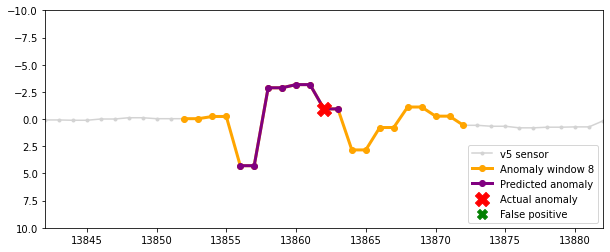

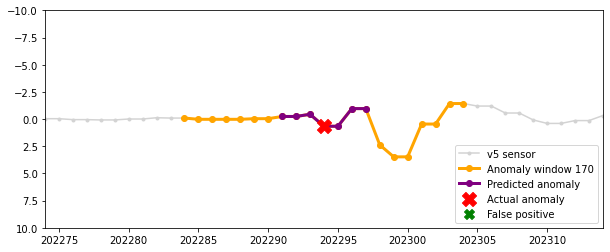

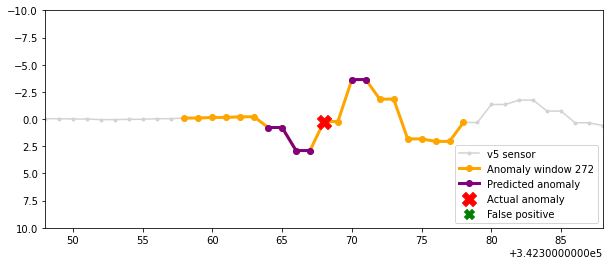

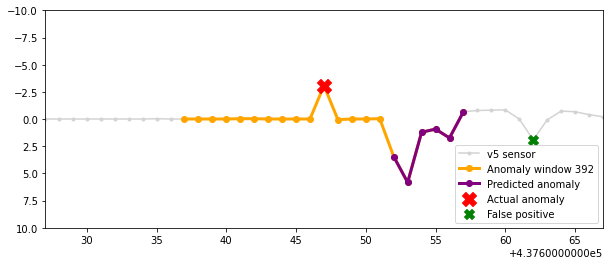

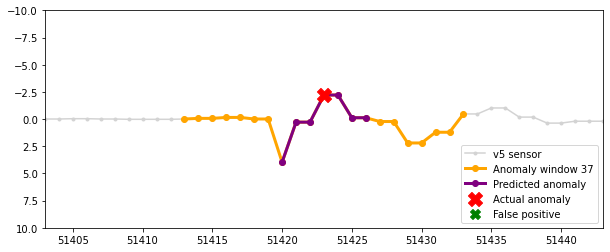

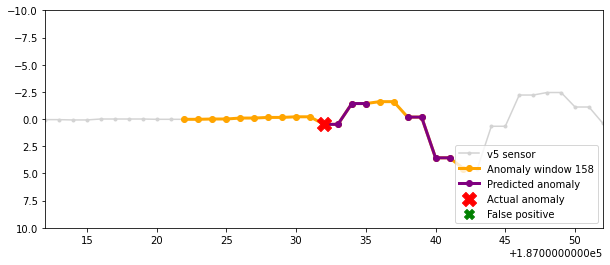

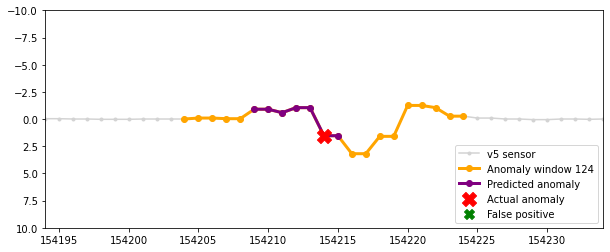

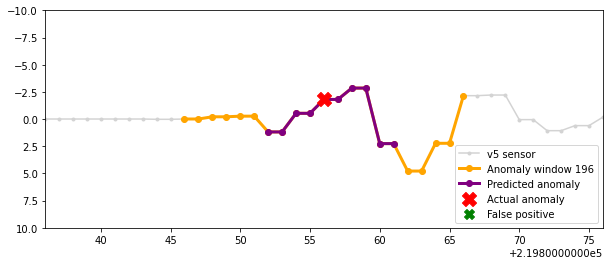

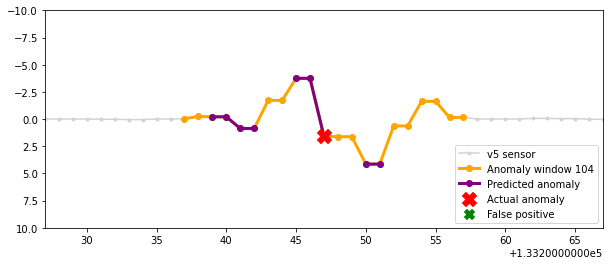

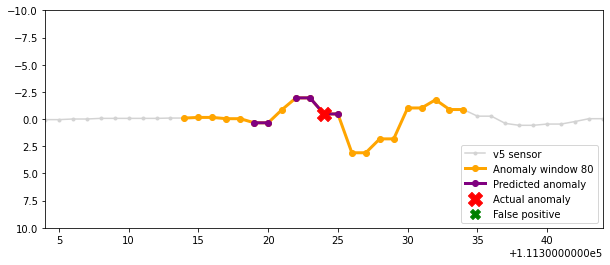

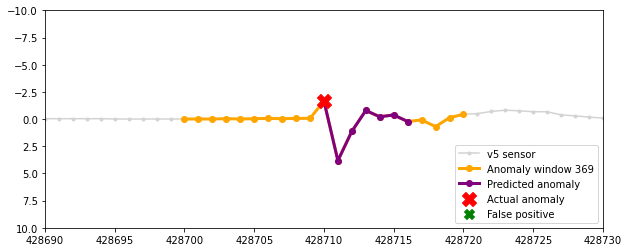

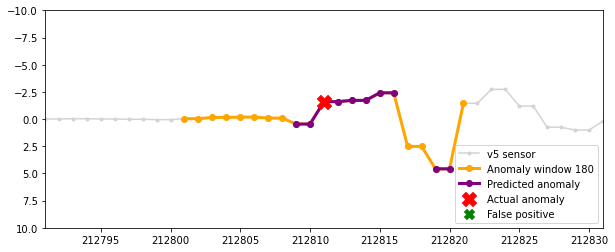

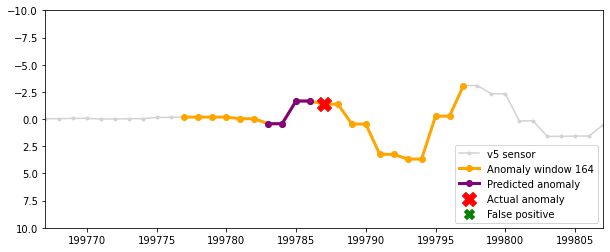

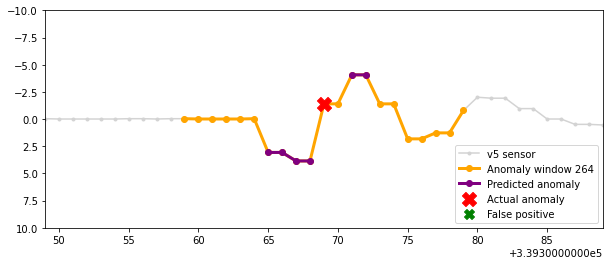

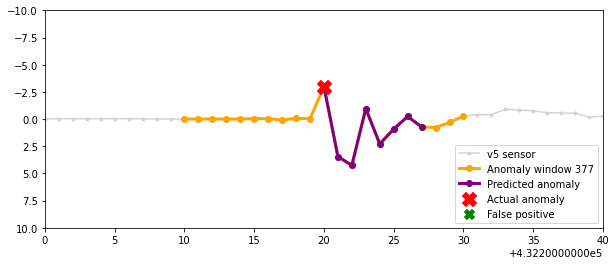

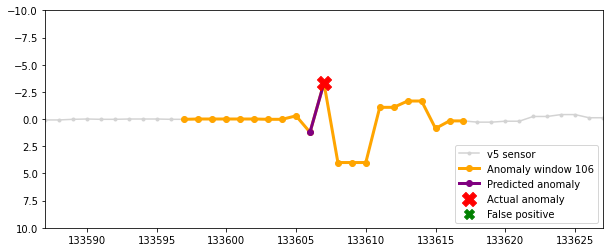

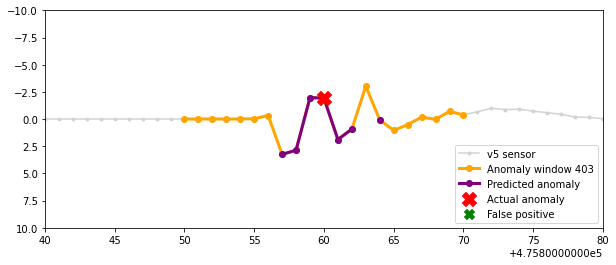

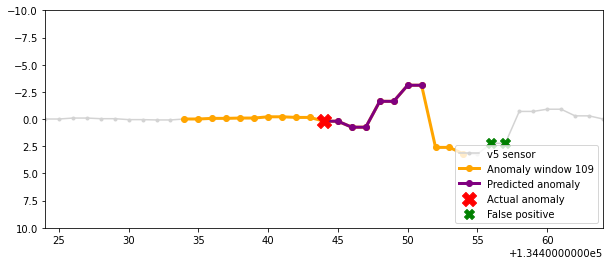

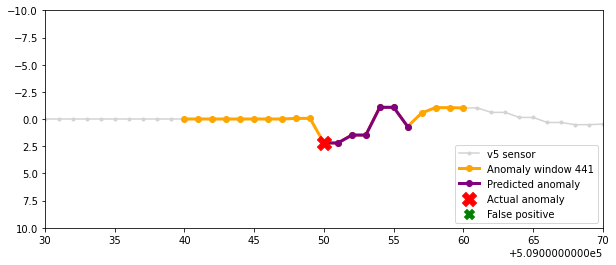

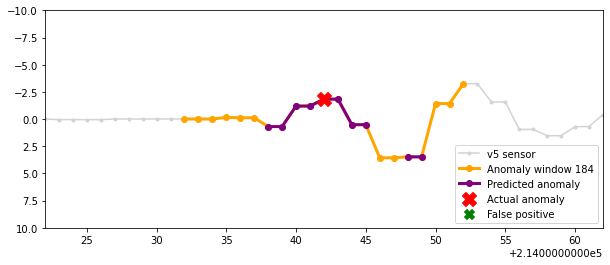

In [67]:
# Now lets plot each window and verify the results
# Inspect the windows that were missed (false negatives)

# By default, plot only a selection of 20 plots (randomly selected)
# Note: It takes a few minutes to plot all & can consume a lot of memory.
PLOT_ALL = False

random_list = []
for i in range(0, 20):
    n = random.randint(1, n_plots)
    random_list.append(n)

if PLOT_ALL:
    plots_list = range(n_plots)
else:
    plots_list = random_list

for p in plots_list:
    fig, ax = plt.subplots(figsize = (10, 4))
    ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'v5 sensor')        
    ax.plot(preds_test['timestamp'], preds_test['v5_win'], color = 'orange', marker = 'o', zorder = 2, linewidth = 3, label = f'Anomaly window {p+1}')
    ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'purple', marker = 'o', zorder = 2, linewidth = 3, label = 'Predicted anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', s = 200, zorder = 3, label = 'Actual anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = 'X', s = 100, zorder = 2, label = 'False positive')
    ax.legend(loc = 'lower right')        
    ax.set_ylim(10, -10)
    ax.set_xlim(start_win[p], ender_win[p])
    plt.show()

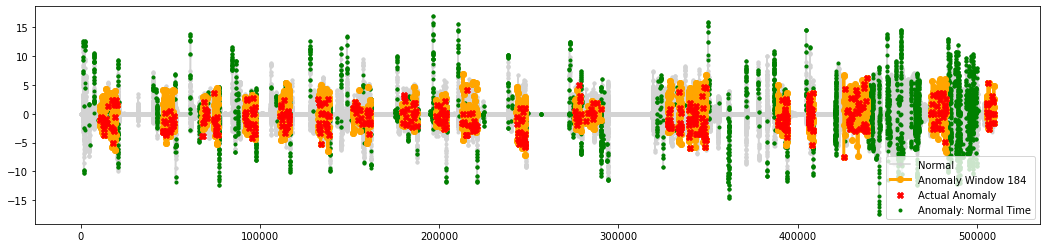

In [68]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')        
ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'orange', marker = 'o', zorder = 3, linewidth = 3, label = f'Anomaly Window {p+1}')
ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', zorder = 4, label = 'Actual Anomaly')
ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.legend(loc = 'lower right')
plt.show()

### MODEL 4. Isolation Forest

An Isolation Forest is a tree-based unsupervised model.  In an Isolation Forest, randomly sub-sampled data are processed in a tree structure based on randomly selected features. Samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.

In [69]:
from sklearn.ensemble import IsolationForest

In [78]:
# Train isolation forest 
isfo_model =  IsolationForest(contamination = 0.02) # 2%
isfo_model.fit(df_train)

IsolationForest(contamination=0.02)

In [79]:
# Predict for train set (normal operating)
preds = pd.Series(isfo_model.predict(df_train))
test = pd.DataFrame({'v5':pd.Series(df_train['v5'])})
isfo_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
v5 = df_train['v5']
v5 = v5.reset_index()
v5.drop('timestamp', axis = 1, inplace = True)
isfo_out['v5'] = v5
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'v5']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly0 = isfo_aly

10008 out of 500352 (2.0%)


In [80]:
# Predict for test set
preds = pd.Series(isfo_model.predict(df_test1))
test = pd.DataFrame({'v5':pd.Series(df_test1['v5'])})
isfo_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
v5 = df_test1['v5']
v5 = v5.reset_index()
v5.drop('timestamp', axis = 1, inplace = True)
isfo_out['v5'] = v5
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'v5']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly1 = isfo_aly

1404 out of 9280 (15.13%)


In [81]:
if 'preds_test' in globals(): del preds_test
preds_test = pd.DataFrame({'prediction':isfo_model.predict(df_all)})
preds_test['timestamp'] = df_set_scaled.index
preds_test['prediction'] = preds_test['prediction'].map({1: 0, -1: 1})
preds_test['status'] = df_set_scaled['status']
preds_test.loc[preds_test['timestamp'].isin(df_train.index), 'zone'] = 'Normal'
preds_test.loc[preds_test['timestamp'].isin(df_test1.index), 'zone'] = 'Anomaly'
preds_test['v5'] = df_set_scaled['v5'] 

# Create some params that will help with visualization of anomaly 
# windows + analysis of prediction results 
preds_test = preds_test.assign(v5_win = preds_test['v5'])
preds_test.loc[preds_test['zone'] == 'Normal', ['v5_win']] = None
preds_test = preds_test.assign(v5_win_anom = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_win_anom']] = None
preds_test.loc[preds_test['zone'] != 'Anomaly', ['v5_win_anom']] = None
preds_test = preds_test.assign(v5_win_actual_anom = preds_test['v5'])
preds_test.loc[preds_test['status'] != 'Abnormal', ['v5_win_actual_anom']] = None
preds_test = preds_test.assign(v5_false_pos = preds_test['v5'])
preds_test.loc[preds_test['prediction'] != 1, ['v5_false_pos']] = None
preds_test.loc[preds_test['zone'] != 'Normal', ['v5_false_pos']] = None
#preds_test.iloc[10690:10715,:]

In [82]:
calculate_normal_zone_acc(preds_test)
print('\n')
calculate_anomaly_zone_acc(preds_test)

Model performance for normal windows:
Total rows: 500,352
TN: True negative (normal pts correctly assigned normal): 490,344 (98.0%)
FP: False positive (normal pts incorrectly assigned anomaly): 10,008 (2.0%)


Model performance for anomaly windows:
Found 371 out of 430 (TP: 86.28%)
Missed 59 out of 430 (FN: 13.72%)

     anom_num  anom_chk
1           2         0
14         15         0
43         44         0
45         46         0
47         48         0
62         63         0
64         65         0
66         67         0
82         83         0
109       110         0
124       125         0
125       126         0
128       129         0
141       142         0
146       147         0
149       150         0
150       151         0
157       158         0
158       159         0
161       162         0
162       163         0
166       167         0
169       170         0
170       171         0
172       173         0
174       175         0
178       179         0
180       

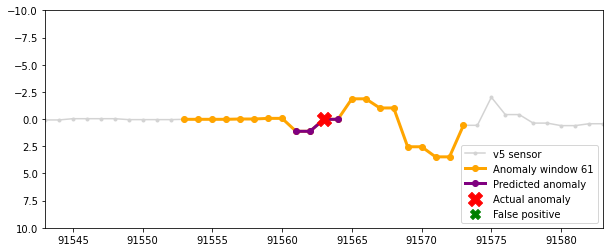

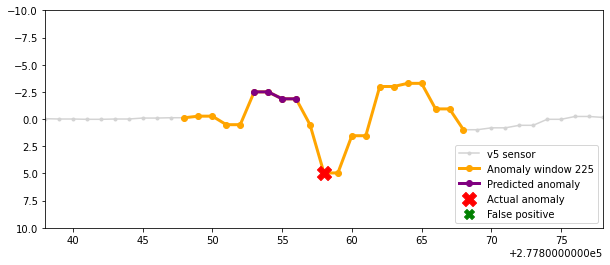

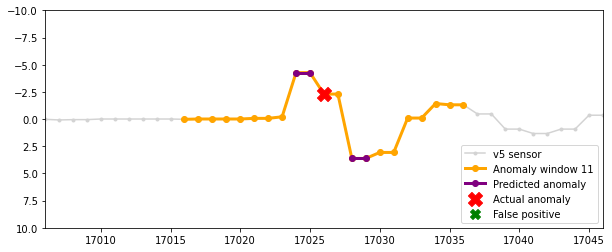

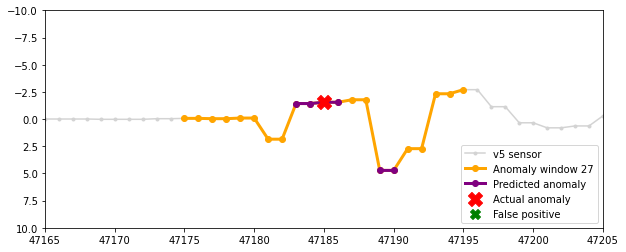

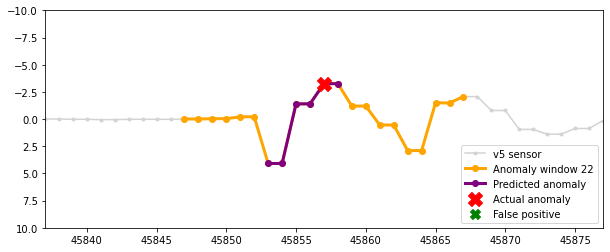

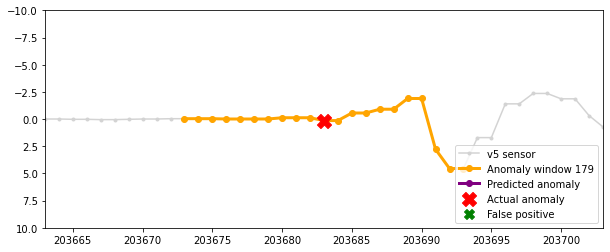

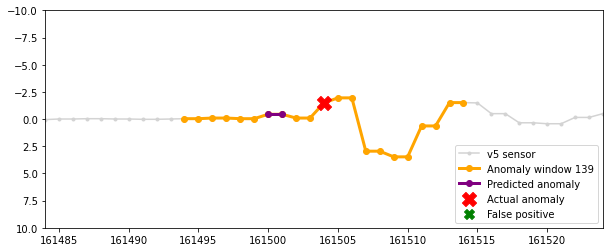

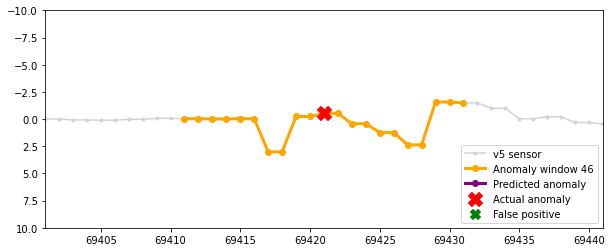

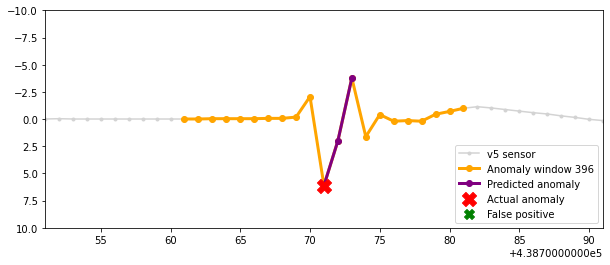

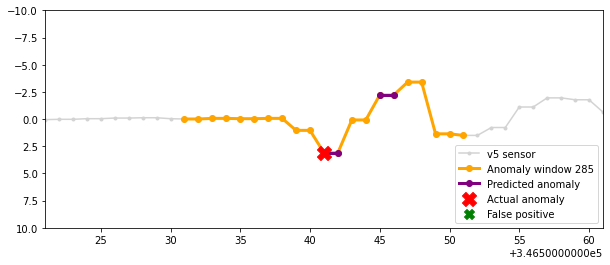

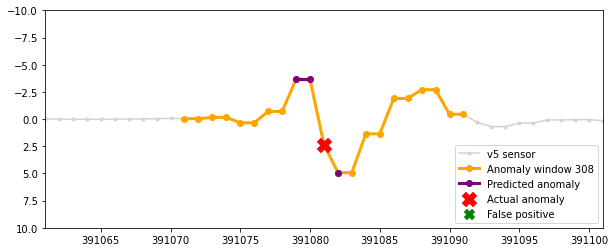

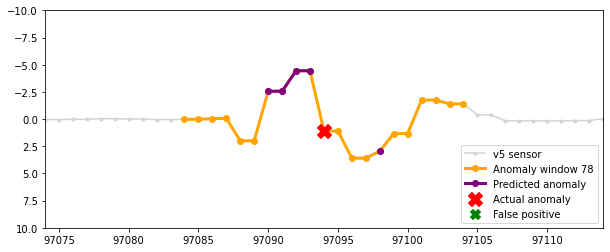

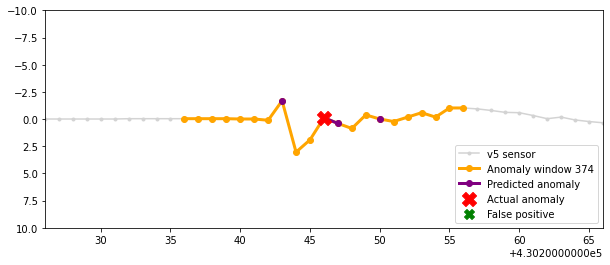

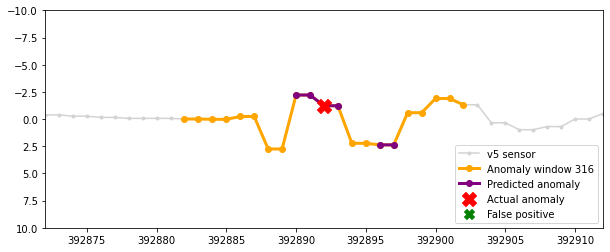

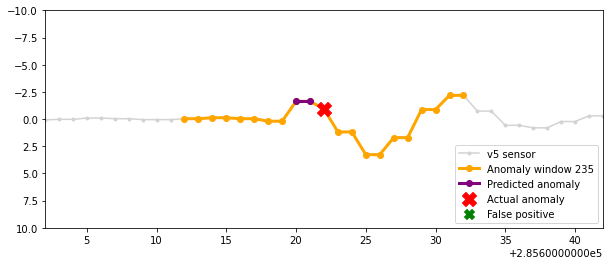

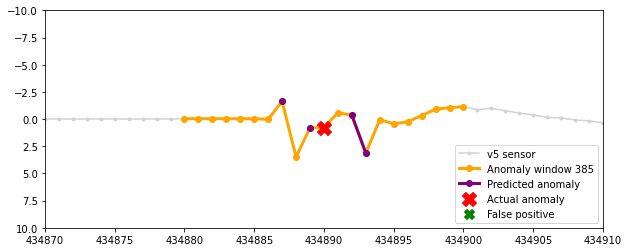

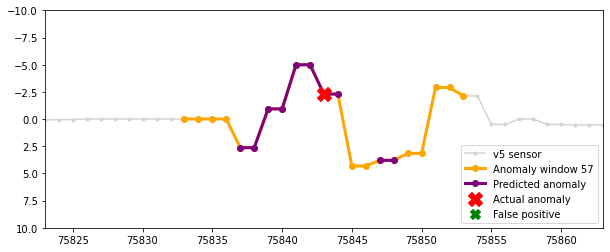

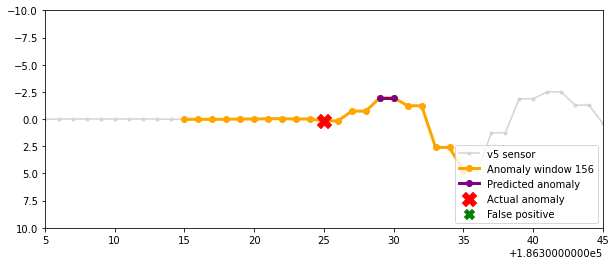

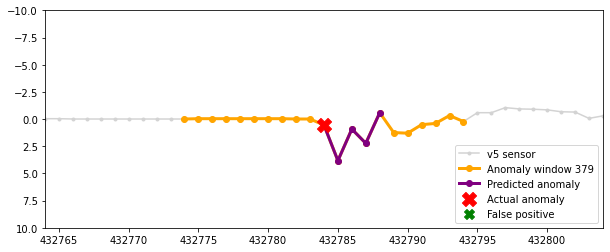

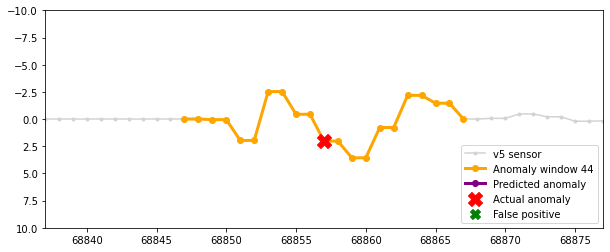

In [83]:
# Now lets plot each window and verify the results
# Inspect the windows that were missed (false negatives)

# By default, plot only a selection of 20 plots (randomly selected)
# Note: It takes a few minutes to plot all & can consume a lot of memory.
PLOT_ALL = False

random_list = []
for i in range(0, 20):
    n = random.randint(1, n_plots)
    random_list.append(n)

if PLOT_ALL:
    plots_list = range(n_plots)
else:
    plots_list = random_list

for p in plots_list:
    fig, ax = plt.subplots(figsize = (10, 4))
    ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'v5 sensor')        
    ax.plot(preds_test['timestamp'], preds_test['v5_win'], color = 'orange', marker = 'o', zorder = 2, linewidth = 3, label = f'Anomaly window {p+1}')
    ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'purple', marker = 'o', zorder = 2, linewidth = 3, label = 'Predicted anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', s = 200, zorder = 3, label = 'Actual anomaly')
    ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = 'X', s = 100, zorder = 2, label = 'False positive')
    ax.legend(loc = 'lower right')        
    ax.set_ylim(10, -10)
    ax.set_xlim(start_win[p], ender_win[p])
    plt.show()

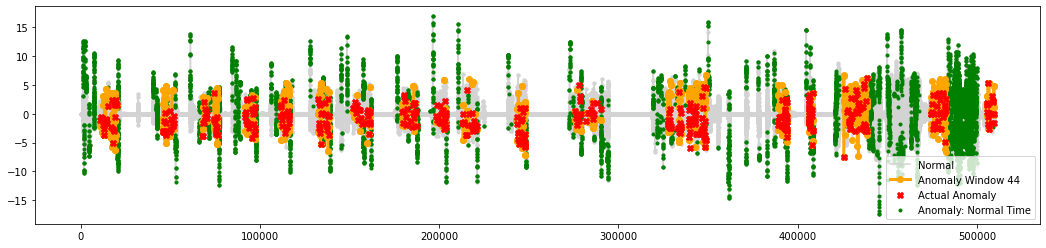

In [84]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(preds_test['timestamp'], preds_test['v5'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')        
ax.plot(preds_test['timestamp'], preds_test['v5_win_anom'], color = 'orange', marker = 'o', zorder = 3, linewidth = 3, label = f'Anomaly Window {p+1}')
ax.scatter(preds_test['timestamp'], preds_test['v5_win_actual_anom'], color = 'red', marker = 'X', zorder = 4, label = 'Actual Anomaly')
ax.scatter(preds_test['timestamp'], preds_test['v5_false_pos'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.legend(loc = 'lower right')
plt.show()

### MODEL 5. Autoencoder LSTM

An autoencoder is a type of ANN that is used to learn efficient codings of unlabeled data (i.e., unsupervised learning).  In this autoencoder model, Long Short-Term Memory (LSTM) neural network cells are used. LSTM networks are a sub-type of the more general recurrent neural networks (RNN). A key attribute of recurrent neural networks is their ability to persist information, or cell state, for use later in the network. This makes them particularly well suited for analysis of time series data.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import keras

In [ ]:
# set random seed
seed(13)
tf.random.set_seed(13)

In [ ]:
# Refresh the data
df_train = df_train#.to_numpy()
df_test1 = df_test1#.to_numpy()

In [ ]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_train = df_train.reshape(df_train.shape[0], 1, df_train.shape[1])
print("Training data shape:", X_train.shape)

X_test1 = df_test1.reshape(df_test1.shape[0], 1, df_test1.shape[1])
print("Test data 1 shape:", X_test1.shape)

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(64, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Create the autoencoder model
model = autoencoder_model(X_train)
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

In [ ]:
# Fit the model to the data
nb_epochs = 20
batch_size = 1000
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.10).history

In [ ]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train.index

scored = pd.DataFrame(index=df_train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0, 0.5])

In [ ]:
def calc_test_loss(test, test_df, thresh):
    # Calculate the loss on the test set 1
    X_pred = model.predict(test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_df.columns)
    X_pred.index = test_df.index

    scored = pd.DataFrame(index=test_df.index)
    Xtest = test.reshape(test.shape[0], test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)
    scored['Threshold'] = thresh
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    print(scored.head())
    return(scored)

In [ ]:
# Calculate the loss on the test set 1
selected_threshold = 0.12
scored1 = calc_test_loss(X_test1, df_test1, selected_threshold)

In [ ]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train.columns)
X_pred_train.index = df_train.index

scored_train = pd.DataFrame(index=df_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.12
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

scored = pd.concat([scored_train, scored1])
scored.head()

In [ ]:
# plot bearing failure time plot
scored.plot(logy = True,  figsize=(16, 9), ylim=[1e-2, 1e2], color=['blue','red'])

In [ ]:
scored['Threshold'].unique()

In [ ]:
# Save all model information, including weights, in h5 format
model.save("auto_lstm_ak.h5")
print("Model saved")